In [162]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import random, os, pathlib, time
from tqdm import tqdm
from sklearn import datasets

In [163]:
import nflib
from nflib.flows import SequentialFlow, NormalizingFlow, ActNorm, AffineConstantFlow
import nflib.coupling_flows as icf
import nflib.inn_flow as inn
import nflib.res_flow as irf

In [164]:
from torch import distributions
from torch.distributions import MultivariateNormal

In [165]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

## MNIST dataset

In [166]:
import mylibrary.datasets as datasets
import mylibrary.nnlib as tnn

In [167]:
mnist = datasets.FashionMNIST()
# mnist.download_mnist()
# mnist.save_mnist()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

# train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [168]:
## converting data to pytorch format
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
train_label = torch.LongTensor(train_label_)
test_label = torch.LongTensor(test_label_)

In [169]:
input_size = 784
output_size = 10

In [170]:
class MNIST_Dataset(data.Dataset):
    
    def __init__(self, data, label):
        self.data = data
        self.label = label
        
#         self.label = mask.type(torch.float32).reshape(-1,1)
        self._shuffle_data_()
        
    def __len__(self):
        return len(self.data)
    
    def _shuffle_data_(self):
        randidx = random.sample(range(len(self.data)), k=len(self.data))
        self.data = self.data[randidx]
        self.label = self.label[randidx]
    
    def __getitem__(self, idx):
        img, lbl = self.data[idx], self.label[idx]
        return img, lbl

In [171]:
train_dataset = MNIST_Dataset(train_data, train_label)
test_dataset = MNIST_Dataset(test_data, test_label)

In [172]:
class ConnectedClassifier_Softmax(nn.Module):
    
    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
        self.linear = nn.Linear(input_dim, num_sets)
        self.linear.bias.data *= 0
        self.linear.weight.data *= 0.1
        self.cls_weight = nn.Parameter(torch.ones(num_sets, output_dim)/output_dim)
        self.cls_confidence = None
        
        
    def forward(self, x, hard=True):
        x = self.linear(x)
        if hard:
            x = torch.softmax(-x*1e5, dim=1)
        else:
            x = torch.softmax(-x*self.inv_temp, dim=1)
        self.cls_confidence = x
        c = torch.softmax(self.cls_weight, dim=1)
#         c = self.cls_weight
        return x@c ## since both are normalized, it is also normalized

In [173]:
# class ConnectedClassifier_SoftKMeans(nn.Module):
    
#     def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
#         super().__init__()
#         self.input_dim = input_dim
#         self.output_dim = output_dim
#         self.num_sets = num_sets
#         self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
#         self.centers = nn.Parameter(torch.rand(num_sets, input_dim)*2-1)
        
# #         self.cls_weight = nn.Parameter(torch.ones(num_sets, output_dim)/output_dim)

#         init_val = torch.randn(num_sets, output_dim)*0.01
#         for ns in range(num_sets):
#             init_val[ns, ns%output_dim] = 10.
#         self.cls_weight = nn.Parameter(init_val)

#         self.cls_confidence = None
        
        
#     def forward(self, x, hard=False):
#         x = x[:, :self.input_dim]
#         dists = torch.cdist(x, self.centers)
#         dists = dists/np.sqrt(self.input_dim) ### correction to make diagonal of unit square 1 in nD space
        
#         if hard:
#             x = torch.softmax(-dists*1e5, dim=1)
#         else:
#             x = torch.softmax(-dists*self.inv_temp, dim=1)
#         self.cls_confidence = x
#         c = torch.softmax(self.cls_weight, dim=1)
# #         c = self.cls_weight
#         return x@c ## since both are normalized, it is also normalized

In [174]:
class ConnectedClassifier_SoftKMeans(nn.Module):
    
    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
        self.centers = nn.Parameter(torch.rand(num_sets, input_dim)*2-1)
        
#         self.cls_weight = nn.Parameter(torch.ones(num_sets, output_dim)/output_dim)
        init_val = torch.randn(num_sets, output_dim)*0.01
        for ns in range(num_sets):
            init_val[ns, ns%output_dim] = 2.
#             init_val[ns, 0] = 2. ### initialize same class in all clusters

        self.cls_weight = nn.Parameter(init_val)

        self.cls_confidence = None
        
        
    def forward(self, x, hard=False):
        self.cls_weight.data = torch.abs(self.cls_weight.data)/self.cls_weight.data.sum(dim=1, keepdim=True)
        
        x = x[:, :self.input_dim]
        dists = torch.cdist(x, self.centers)
        dists = dists/np.sqrt(self.input_dim) ### correction to make diagonal of unit square 1 in nD space
        
        if hard:
            x = torch.softmax(-dists*1e5, dim=1)
        else:
            x = torch.softmax(-dists*self.inv_temp, dim=1)
        self.cls_confidence = x
#         c = torch.softmax(self.cls_weight, dim=1)
        c = self.cls_weight
        return x@c ## since both are normalized, it is also normalized

In [175]:
actf = irf.Swish
flows = [
    ActNorm(784),
    irf.ResidualFlow(784, [784], activation=actf),
#     ActNorm(784),
#     irf.ResidualFlow(784, [784], activation=actf),
    ActNorm(784),
        ]

model = SequentialFlow(flows)
model = model.to(device)

In [176]:
# model = nn.Sequential(nn.Linear(784, 784, bias=False),
#                       nn.BatchNorm1d(784),
#                       nn.SELU(),
#                       nn.Linear(784, 784, bias=False),
#                       nn.BatchNorm1d(784),
#                       nn.SELU(),
#                      )

In [177]:
model.to(device)

SequentialFlow(
  (flows): ModuleList(
    (0): ActNorm()
    (1): ResidualFlow(
      (resblock): ModuleList(
        (0): Linear(in_features=784, out_features=784, bias=True)
        (1): Swish()
        (2): Linear(in_features=784, out_features=784, bias=True)
      )
    )
    (2): ActNorm()
  )
)

In [178]:
list(model.flows[0].parameters())

[Parameter containing:
 tensor([[ 6.0879e-02,  4.7052e-01,  1.5419e+00,  4.9037e-01,  8.0200e-01,
           1.6113e+00, -8.1295e-01, -4.7921e-01, -1.1205e-01, -2.9567e-01,
          -8.4255e-01,  7.6563e-01,  4.8338e-01,  3.7558e-02,  1.6155e-02,
           2.1661e+00, -8.6482e-01, -8.8266e-01, -1.8505e-01,  1.0119e+00,
           8.5505e-01, -1.2850e+00,  6.8480e-01, -3.6080e-01,  1.4888e+00,
          -1.1909e+00, -1.4475e+00, -6.0214e-01,  1.5394e-01,  4.9674e-01,
           3.0474e+00,  1.0779e+00, -1.9401e-01,  1.3881e+00, -2.9547e-01,
           7.0096e-01, -7.3939e-02,  1.1315e+00,  3.4936e-01,  1.6948e-01,
          -3.4728e-01,  2.4789e-01, -1.4595e-01,  2.1112e+00,  1.1631e+00,
          -8.2610e-03, -5.4326e-01,  1.1629e-01, -1.0588e+00,  1.6728e+00,
           1.0165e+00,  5.6982e-01, -1.9235e+00,  4.4650e-01, -7.6703e-01,
          -4.4855e-01, -1.0200e+00, -2.0108e+00, -1.2680e+00,  1.1153e+00,
           5.2932e-01,  2.1707e+00, -2.8782e-01,  1.9809e+00, -3.4248e-01,
  

In [179]:
classifier = ConnectedClassifier_SoftKMeans(784, 10, 10)
# classifier = ConnectedClassifier_Softmax(784, 10, 10)
classifier = classifier.to(device)

## Model Train

In [180]:
learning_rate = 0.0003
batch_size = 50

In [181]:
train_loader = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=False)

In [183]:
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(list(model.parameters())+list(classifier.parameters()),
                       lr=learning_rate, weight_decay=1e-15) # todo tune WD
# optimizer = optim.SGD(model.parameters(), lr=0.1)

print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  1234017


In [184]:
for p in model.parameters():
    print(torch.isnan(p).type(torch.float32).sum())

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


In [185]:
model(torch.randn(10, 784).to(device))

tensor([[ 0.8518,  0.1573,  0.4854,  ...,  0.5949,  0.5361,  0.3171],
        [-0.6932, -0.6211,  0.3549,  ..., -0.3628, -0.3816,  0.8726],
        [ 0.5468,  0.1441, -1.8372,  ...,  0.2548,  0.9269, -1.0853],
        ...,
        [-0.7946, -0.6762, -1.6192,  ..., -2.2075, -0.4630,  0.2130],
        [ 1.2937,  1.7893,  0.2086,  ..., -0.1162,  0.2609,  0.4911],
        [-1.7278,  0.4854,  0.6810,  ..., -0.6426,  1.9380,  1.2018]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [186]:
xx = iter(test_loader).next()[0]
xx.shape

torch.Size([50, 784])

In [187]:
losses = []
train_accs = []
test_accs = []
EPOCHS = 50

index = 0
for epoch in range(EPOCHS):
    train_acc = 0
    train_count = 0
    for xx, yy in tqdm(train_loader):
        xx, yy = xx.to(device), yy.to(device)
#     for xx, yy in tqdm(test_loader):

        yout = model(xx)
#         print(yout)
        yout = classifier(yout)    
#         print(yout)
        loss = criterion(yout, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(float(loss))

        outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        train_acc += correct
        train_count += len(outputs)
#         break

    train_accs.append(float(train_acc)/train_count*100)
    train_acc = 0
    train_count = 0

    print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}')
    test_count = 0
    test_acc = 0
    for xx, yy in tqdm(test_loader):
        xx, yy = xx.to(device), yy.to(device)
        with torch.no_grad():
            yout = classifier(model(xx))    
        outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        test_acc += correct
        test_count += len(xx)
    test_accs.append(float(test_acc)/test_count*100)
    print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
    print()

### after each class index is finished training
print(f'\t-> Train Acc {max(train_accs)} ; Test Acc {max(test_accs)}')

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 0:0,  Loss:2.247366189956665


  0%|          | 0/1200 [00:00<?, ?it/s]

Train Acc:55.76%, Test Acc:65.20%



 26%|██▌       | 306/1200 [00:01<00:03, 229.51it/s]


KeyboardInterrupt: 

In [26]:
# classifier.cls_weight

### Hard test accuracy with count per classifier

In [131]:
test_count = 0
test_acc = 0
set_count = torch.zeros(classifier.num_sets).to(device)
for xx, yy in tqdm(test_loader):
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
        yout = classifier(model(xx), hard=True)
        set_indx, count = torch.unique(torch.argmax(classifier.cls_confidence, dim=1), return_counts=True) 
        set_count[set_indx] += count
    outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
    correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
    test_acc += correct
    test_count += len(xx)

print(f'Hard Test Acc:{float(test_acc)/test_count*100:.2f}%')
print(set_count.type(torch.long).tolist())

100%|██████████| 200/200 [00:00<00:00, 288.51it/s]

Hard Test Acc:89.14%
[1, 13, 1002, 0, 943, 0, 0, 0, 769, 965, 0, 11, 0, 4, 0, 0, 0, 0, 3, 0, 0, 0, 0, 20, 0, 0, 0, 0, 14, 0, 0, 2, 0, 21, 1014, 213, 0, 0, 5, 0, 0, 2, 0, 65, 0, 0, 0, 0, 85, 29, 0, 0, 0, 0, 0, 0, 0, 0, 19, 0, 0, 0, 0, 0, 0, 24, 0, 996, 37, 0, 0, 951, 0, 411, 0, 744, 0, 0, 30, 0, 0, 0, 0, 500, 0, 0, 0, 0, 27, 0, 1038, 0, 0, 0, 0, 16, 0, 0, 10, 16]


### Hard train accuracy with count per classifier

In [132]:
test_count = 0
test_acc = 0
set_count = torch.zeros(classifier.num_sets).to(device)
for xx, yy in tqdm(train_loader):
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
        yout = classifier(model(xx), hard=True)
        set_indx, count = torch.unique(torch.argmax(classifier.cls_confidence, dim=1), return_counts=True) 
        set_count[set_indx] += count
    outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
    correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
    test_acc += correct
    test_count += len(xx)

print(f'Hard Train Acc:{float(test_acc)/test_count*100:.2f}%')
print(set_count.type(torch.long).tolist())

100%|██████████| 1200/1200 [00:03<00:00, 373.46it/s]

Hard Train Acc:94.66%
[0, 50, 5931, 1, 5707, 0, 0, 0, 4621, 5778, 0, 45, 0, 43, 0, 0, 0, 0, 13, 0, 0, 1, 0, 87, 0, 0, 0, 0, 74, 0, 3, 14, 0, 96, 6062, 1293, 0, 0, 38, 0, 0, 15, 0, 404, 0, 0, 0, 0, 563, 184, 0, 0, 0, 0, 0, 0, 0, 0, 85, 0, 0, 0, 0, 0, 0, 62, 0, 5966, 235, 0, 4, 5822, 0, 2466, 0, 4513, 0, 0, 154, 0, 1, 0, 0, 3081, 0, 0, 0, 0, 166, 0, 6171, 3, 0, 0, 0, 128, 0, 0, 40, 80]


In [133]:
#### Classifiers that enclose any data
torch.count_nonzero(set_count)

tensor(39, device='cuda:0')

In [134]:
#### classifier with class representation
torch.argmax(classifier.cls_weight, dim=1)

tensor([6, 1, 2, 3, 6, 5, 6, 7, 8, 9, 6, 1, 2, 3, 6, 5, 6, 7, 8, 9, 6, 1, 2, 3,
        6, 5, 6, 7, 8, 9, 6, 1, 2, 3, 4, 5, 6, 7, 8, 9, 6, 1, 2, 3, 6, 5, 6, 7,
        8, 9, 6, 1, 2, 3, 6, 5, 6, 7, 8, 9, 6, 1, 2, 3, 6, 5, 6, 7, 8, 9, 6, 1,
        2, 3, 6, 5, 6, 7, 8, 9, 6, 1, 2, 3, 6, 5, 6, 7, 8, 9, 0, 1, 2, 3, 6, 5,
        6, 7, 8, 9], device='cuda:0')

In [135]:
# The class labels are same as that of initialized
# tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
#         4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
#         8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
#         2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5,
#         6, 7, 8, 9], device='cuda:0')

In [136]:
classifier.cls_weight

Parameter containing:
tensor([[4.9609e-01, 1.7493e-03, 2.1725e-05, 2.4559e-05, 2.6216e-05, 2.4398e-05,
         5.0199e-01, 2.3915e-05, 2.4430e-05, 2.4014e-05],
        [4.2563e-05, 9.9959e-01, 4.5189e-05, 4.2100e-05, 4.2970e-05, 4.3756e-05,
         4.5557e-05, 4.3541e-05, 4.2540e-05, 5.8303e-05],
        [7.7947e-05, 2.1121e-04, 9.9852e-01, 1.0617e-04, 9.5605e-05, 2.1280e-04,
         1.7927e-04, 2.1343e-04, 1.7339e-04, 2.1334e-04],
        [6.0754e-05, 3.5400e-05, 3.1255e-05, 9.9971e-01, 2.6190e-05, 3.1556e-05,
         3.0706e-06, 3.3729e-05, 3.4109e-05, 3.4534e-05],
        [1.2727e-04, 6.5118e-05, 5.8687e-05, 1.7527e-04, 1.2002e-04, 1.0372e-04,
         9.9899e-01, 7.0291e-05, 2.2402e-04, 7.0415e-05],
        [3.9248e-05, 6.3500e-05, 6.4315e-05, 6.3449e-05, 5.7923e-05, 9.9939e-01,
         6.3853e-05, 3.8521e-05, 8.1111e-05, 1.4178e-04],
        [2.0906e-01, 8.8912e-06, 2.6898e-01, 4.8045e-06, 6.3313e-03, 8.0068e-06,
         5.0817e-01, 7.5560e-06, 7.4101e-03, 8.6027e-06],
     

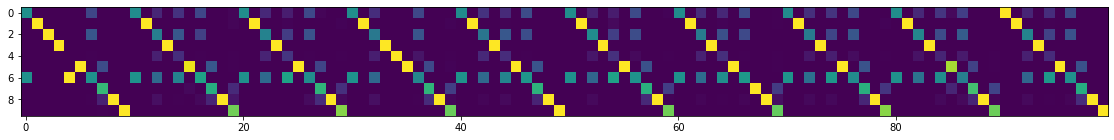

In [137]:
plt.figure(figsize=(20,2))
plt.imshow(classifier.cls_weight.data.cpu().t())

In [138]:
# torch.unique(torch.argmax(classifier.cls_confidence, dim=1), return_counts=True)

In [139]:
classifier.inv_temp

Parameter containing:
tensor([11.9853], device='cuda:0', requires_grad=True)

In [140]:
### example output per classifier
yout[5]

tensor([1.1995e-04, 1.1991e-04, 1.2000e-04, 1.1995e-04, 1.1993e-04, 1.3888e-04,
        1.1829e-04, 9.9891e-01, 1.2736e-04, 1.0101e-04], device='cuda:0')

In [141]:
asdfsdf ## to break the code

NameError: name 'asdfsdf' is not defined

### analyze per classifier accuracy

In [142]:
test_count = 0
test_acc = 0
set_count = torch.zeros(classifier.num_sets).to(device)
set_acc = torch.zeros(classifier.num_sets).to(device)
for xx, yy in tqdm(train_loader):
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
        yout = classifier(model(xx), hard=True)
        
    cls_indx = torch.argmax(classifier.cls_confidence, dim=1)
    set_indx, count = torch.unique(cls_indx, return_counts=True) 
    set_count[set_indx] += count
    
    outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
    correct = (outputs == yy.data.cpu().numpy()).astype(float)
    
    ### class_index has 100 possible values
    for i, c in enumerate(correct):
        set_acc[cls_indx[i]] += c
    
#     print(set_acc.sum(), set_count.sum())
#     break
    test_acc += correct.sum()
    test_count += len(xx)

print(f'Hard Train Acc:{float(test_acc)/test_count*100:.2f}%')
print(set_count.type(torch.long).tolist())

100%|██████████| 1200/1200 [00:04<00:00, 242.03it/s]

Hard Train Acc:94.66%
[0, 50, 5931, 1, 5707, 0, 0, 0, 4621, 5778, 0, 45, 0, 43, 0, 0, 0, 0, 13, 0, 0, 1, 0, 87, 0, 0, 0, 0, 74, 0, 3, 14, 0, 96, 6062, 1293, 0, 0, 38, 0, 0, 15, 0, 404, 0, 0, 0, 0, 563, 184, 0, 0, 0, 0, 0, 0, 0, 0, 85, 0, 0, 0, 0, 0, 0, 62, 0, 5966, 235, 0, 4, 5822, 0, 2466, 0, 4513, 0, 0, 154, 0, 1, 0, 0, 3081, 0, 0, 0, 0, 166, 0, 6171, 3, 0, 0, 0, 128, 0, 0, 40, 80]


In [143]:
set_acc/set_count

tensor([   nan, 0.9600, 0.9074, 1.0000, 0.8847,    nan,    nan,    nan, 0.9959,
        0.9782,    nan, 0.9778,    nan, 0.8140,    nan,    nan,    nan,    nan,
        0.8462,    nan,    nan, 1.0000,    nan, 0.6207,    nan,    nan,    nan,
           nan, 0.9865,    nan, 1.0000, 0.9286,    nan, 0.9167, 0.8910, 0.9791,
           nan,    nan, 1.0000,    nan,    nan, 1.0000,    nan, 0.8886,    nan,
           nan,    nan,    nan, 0.9751, 0.9293,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan, 0.9882,    nan,    nan,    nan,    nan,
           nan,    nan, 0.8387,    nan, 0.9774, 0.9957,    nan, 1.0000, 0.9974,
           nan, 0.9165,    nan, 0.9949,    nan,    nan, 0.9351,    nan, 1.0000,
           nan,    nan, 0.9760,    nan,    nan,    nan,    nan, 0.9699,    nan,
        0.9117, 0.3333,    nan,    nan,    nan, 0.9766,    nan,    nan, 1.0000,
        0.8875], device='cuda:0')

In [144]:
print(f"idx,\tcls,\tacc \ttot,\tpercent%")
for i, (cnt, acc, cls) in enumerate(zip(set_count.type(torch.long).tolist(),
                                   (set_acc/set_count).tolist(),
                                   torch.argmax(classifier.cls_weight, dim=1).tolist())):
    if cnt == 0: continue
    print(f"{i},\t{cls},\t{int(acc*cnt)}\t{cnt},\t{acc*100:.2f}%")

idx,	cls,	acc 	tot,	percent%
1,	1,	47	50,	96.00%
2,	2,	5382	5931,	90.74%
3,	3,	1	1,	100.00%
4,	6,	5048	5707,	88.47%
8,	8,	4602	4621,	99.59%
9,	9,	5652	5778,	97.82%
11,	1,	44	45,	97.78%
13,	3,	34	43,	81.40%
18,	8,	11	13,	84.62%
21,	1,	1	1,	100.00%
23,	3,	53	87,	62.07%
28,	8,	73	74,	98.65%
30,	6,	3	3,	100.00%
31,	1,	12	14,	92.86%
33,	3,	88	96,	91.67%
34,	4,	5401	6062,	89.10%
35,	5,	1266	1293,	97.91%
38,	8,	38	38,	100.00%
41,	1,	15	15,	100.00%
43,	3,	359	404,	88.86%
48,	8,	549	563,	97.51%
49,	9,	170	184,	92.93%
58,	8,	84	85,	98.82%
65,	5,	51	62,	83.87%
67,	7,	5830	5966,	97.74%
68,	8,	234	235,	99.57%
70,	6,	4	4,	100.00%
71,	1,	5807	5822,	99.74%
73,	3,	2260	2466,	91.65%
75,	5,	4490	4513,	99.49%
78,	8,	143	154,	93.51%
80,	6,	1	1,	100.00%
83,	3,	3007	3081,	97.60%
88,	8,	160	166,	96.99%
90,	0,	5625	6171,	91.17%
91,	1,	1	3,	33.33%
95,	5,	125	128,	97.66%
98,	8,	40	40,	100.00%
99,	9,	70	80,	88.75%


## Centroid Visualization

In [145]:
with torch.no_grad():
    zout = model(xx).cpu()
    xcenters = model.inverse(classifier.centers).cpu()

In [158]:
zz = model(xcenters.to(device)).data.cpu()
torch.norm(zz-classifier.centers.cpu(), dim=1) < 1e-2

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True])

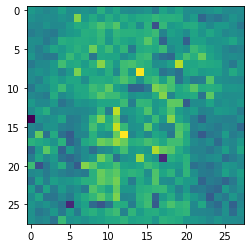

In [161]:
plt.imshow(xcenters[90].reshape(28,28))

## Per classifier data statstics !!

In [58]:
Xs = [] ## input
Ts = [] ## target class
Zs = [] ## transform
Cs = [] ## winning classifier
Os = [] ## output of winning classifier

# set_count = torch.zeros(classifier.num_sets).to(device)
# set_acc = torch.zeros(classifier.num_sets).to(device)
for xx, yy in tqdm(train_loader):
    Xs.append(xx)
    Ts.append(yy)
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
        zz = model(xx)
        yout = classifier(zz, hard=True)
        Zs.append(zz.cpu())
        Os.append(torch.argmax(yout, dim=1).data.cpu())
        
    cls_indx = torch.argmax(classifier.cls_confidence, dim=1)
    Cs.append(cls_indx)

100%|██████████| 1200/1200 [00:03<00:00, 356.44it/s]


In [59]:
Xs = torch.cat(Xs, dim=0)
Zs = torch.cat(Zs, dim=0)
Cs = torch.cat(Cs, dim=0)
Ts = torch.cat(Ts, dim=0)
Os = torch.cat(Os, dim=0)

i:2, cls:4, Xmean:0.3865622878074646, Xstd: 0.3759835958480835
		 Zmean:0.17413507401943207, Zstd: 3.393758773803711


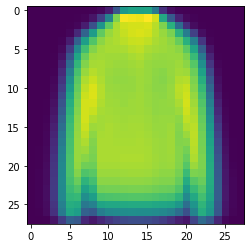

------------------------------
i:8, cls:7, Xmean:0.16964684426784515, Xstd: 0.29640382528305054
		 Zmean:-0.08658542484045029, Zstd: 2.935338020324707


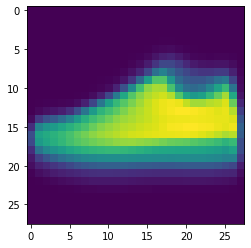

------------------------------
i:11, cls:5, Xmean:0.13557814061641693, Xstd: 0.2617197334766388
		 Zmean:-0.0018334198975935578, Zstd: 3.696573495864868


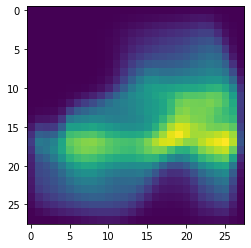

------------------------------
i:26, cls:2, Xmean:0.3772331774234772, Xstd: 0.3564039468765259
		 Zmean:0.2076600044965744, Zstd: 3.2576472759246826


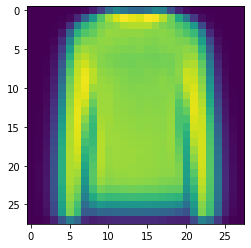

------------------------------
i:27, cls:0, Xmean:0.3226654827594757, Xstd: 0.3489154577255249
		 Zmean:0.05432984605431557, Zstd: 3.2963101863861084


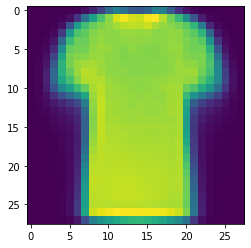

------------------------------
i:33, cls:8, Xmean:0.3543356657028198, Xstd: 0.3653598129749298
		 Zmean:0.2648376524448395, Zstd: 4.418046951293945


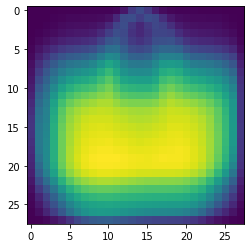

------------------------------
i:59, cls:3, Xmean:0.25739607214927673, Xstd: 0.3534153997898102
		 Zmean:0.14223261177539825, Zstd: 3.390036106109619


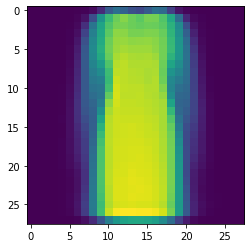

------------------------------
i:62, cls:5, Xmean:0.14705954492092133, Xstd: 0.23726777732372284
		 Zmean:-0.057480402290821075, Zstd: 1.8820605278015137


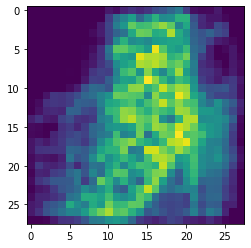

------------------------------
i:65, cls:6, Xmean:0.32160672545433044, Xstd: 0.3288481533527374
		 Zmean:0.15800923109054565, Zstd: 2.5248374938964844


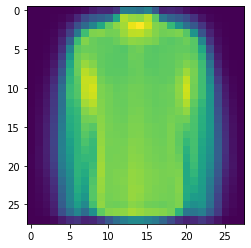

------------------------------
i:96, cls:1, Xmean:0.2229204922914505, Xstd: 0.3439006209373474
		 Zmean:0.023519229143857956, Zstd: 5.20264196395874


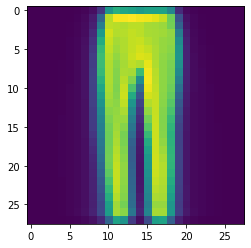

------------------------------
i:98, cls:9, Xmean:0.3061772882938385, Xstd: 0.3723733723163605
		 Zmean:0.02024601399898529, Zstd: 4.269995212554932


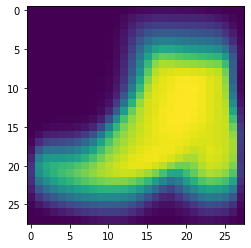

------------------------------


In [60]:
### get all x belonging to classifier 13
# i = 13
for i, (cnt, acc, cls) in enumerate(zip(set_count.type(torch.long).tolist(),
                                   (set_acc/set_count).tolist(),
                                   torch.argmax(classifier.cls_weight, dim=1).tolist())):
    if cnt == 0: continue
    indx = torch.nonzero(Cs == i).reshape(-1)
    xs_ = Xs[indx]
    zs_ = Zs[indx]
    print(f"i:{i}, cls:{cls}, Xmean:{xs_.mean()}, Xstd: {xs_.std()}")
    print(f"\t\t Zmean:{zs_.mean()}, Zstd: {zs_.std()}")
    
    plt.imshow(xs_.mean(dim=0).cpu().reshape(28, 28))
    plt.show()
    
    print("------------------------------")

In [61]:
# Zs[indx]

### Plot of mean and std

i:2, cls:4


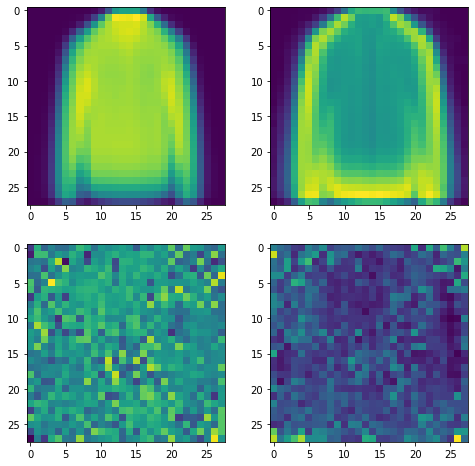

------------------------------
i:8, cls:7


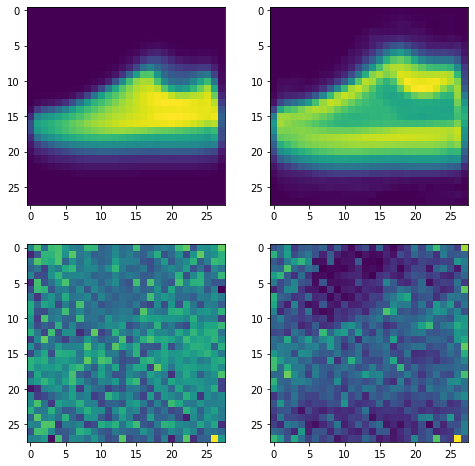

------------------------------
i:11, cls:5


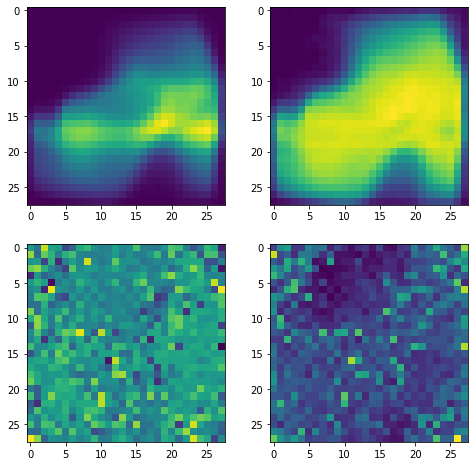

------------------------------
i:26, cls:2


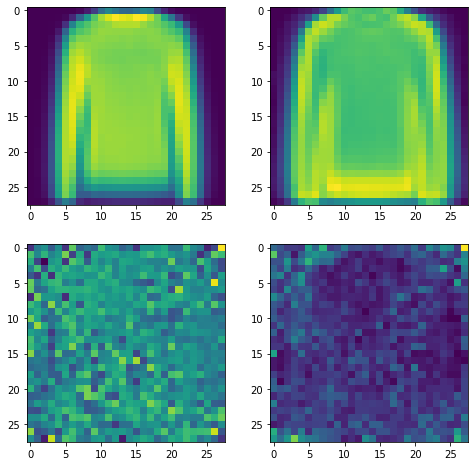

------------------------------
i:27, cls:0


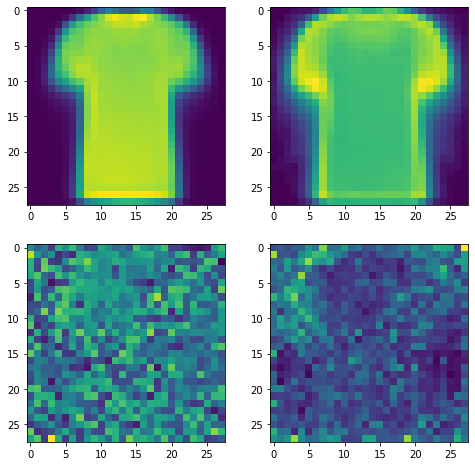

------------------------------
i:33, cls:8


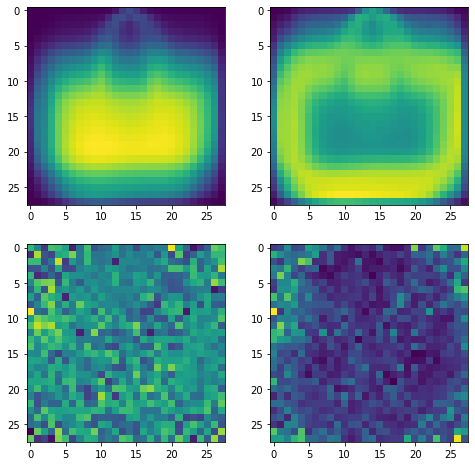

------------------------------
i:59, cls:3


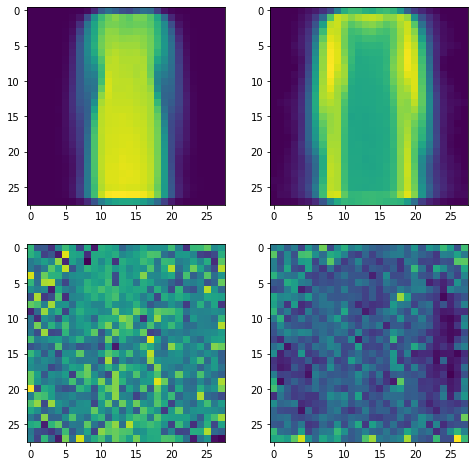

------------------------------
i:62, cls:5


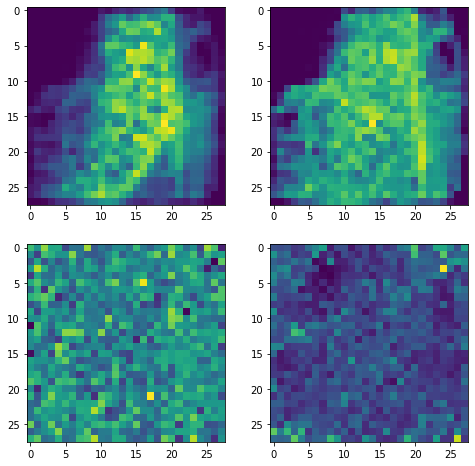

------------------------------
i:65, cls:6


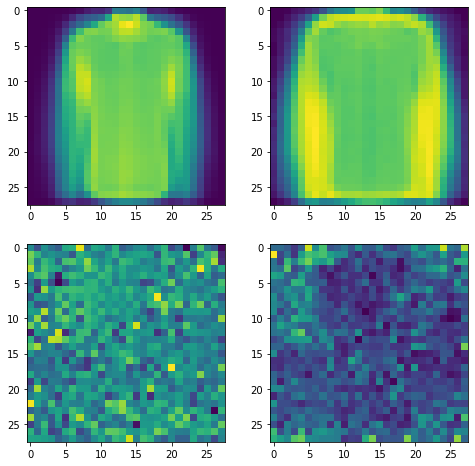

------------------------------
i:96, cls:1


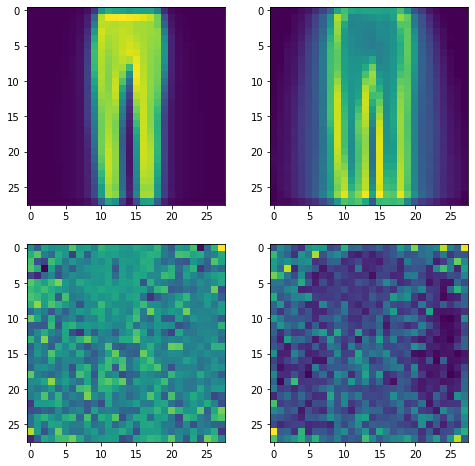

------------------------------
i:98, cls:9


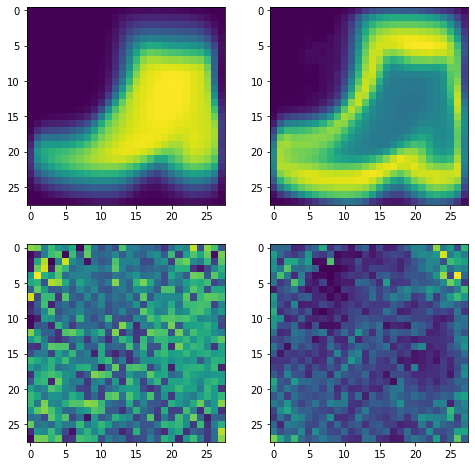

------------------------------


In [62]:
### get all x belonging to classifier (some index i)
for i, (cnt, acc, cls) in enumerate(zip(set_count.type(torch.long).tolist(),
                                   (set_acc/set_count).tolist(),
                                   torch.argmax(classifier.cls_weight, dim=1).tolist())):
    if cnt == 0: continue
    indx = torch.nonzero(Cs == i).reshape(-1)
    xs_ = Xs[indx]
    zs_ = Zs[indx]
    print(f"i:{i}, cls:{cls}")
    
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8,8))
    ax1.imshow(xs_.mean(dim=0).cpu().reshape(28, 28))
    ax2.imshow(xs_.std(dim=0).cpu().reshape(28, 28))
    ax3.imshow(zs_.mean(dim=0).cpu().reshape(28, 28))
    ax4.imshow(zs_.std(dim=0).cpu().reshape(28, 28))
    plt.show()
    
    print("------------------------------")
#     break

In [63]:
indx

tensor([    5,    20,    31,  ..., 59971, 59986, 59997], device='cuda:0')

In [64]:
torch.nonzero(Cs == 62).reshape(-1)

tensor([ 3642,  6284, 12135, 16858, 22416, 30123, 35102, 38015, 40915, 41236,
        42386, 44824, 50695, 51200], device='cuda:0')

In [65]:
Cs.shape

torch.Size([60000])

### Create a stat of classifier after division

In [66]:
classifier_index = []
classifier_count = []

for i, cnt in enumerate(set_count.type(torch.long).tolist()):
    if cnt == 0: continue
    classifier_index.append(i)
    classifier_count.append(int(cnt))

In [67]:
classifier_index, classifier_count

([2, 8, 11, 26, 27, 33, 59, 62, 65, 96, 98],
 [7288, 6343, 5920, 6217, 5953, 5980, 6482, 14, 4169, 5908, 5726])

In [79]:
# Xs = [] ## input
# Ts = [] ## target class
# Zs = [] ## transform
# Cs = [] ## winning classifier
# Os = [] ## output of winning classifier

In [88]:
correct = 0
### get all the X, T belonging to ith classifier (Xi, Ti)
for i in range(len(classifier_index)):
    cls_idx = classifier_index[i]
    data_idx = torch.nonzero(Cs == cls_idx)
    Xi = Xs[data_idx]
    Ti = Ts[data_idx]

    ### get prediction according to data
    cls, count = torch.unique(Ti, return_counts=True, sorted=True)
    pred = cls[torch.argmax(count)]
    correct += (Ti==pred).type(torch.long).sum()
#     break

In [89]:
correct / len(Xs)

tensor(0.8916)

In [99]:
### Entropy per classifier
def get_cross_entropy(p): ## lower is better
    return -torch.sum(p*torch.log(p))

for i in range(len(classifier_index)):
    cls_idx = classifier_index[i]
    data_idx = torch.nonzero(Cs == cls_idx)
    Xi = Xs[data_idx]
    Ti = Ts[data_idx]

    ### get prediction according to data
    cls, count = torch.unique(Ti, return_counts=True, sorted=True)
    pred = cls[torch.argmax(count)]
    p = (Ti==pred).type(torch.float32).mean()
    entropy = get_cross_entropy(p)
    print(f"idx: {cls_idx}\tout: {int(pred)} \t entropy: {entropy:3f} \tclasses:{cls.tolist()}")

idx: 2	out: 4 	 entropy: 0.221581 	classes:[0, 1, 2, 3, 4, 6, 8, 9]
idx: 8	out: 7 	 entropy: 0.071864 	classes:[5, 7, 8, 9]
idx: 11	out: 5 	 entropy: 0.015419 	classes:[0, 1, 2, 5, 7, 8, 9]
idx: 26	out: 2 	 entropy: 0.185905 	classes:[0, 1, 2, 3, 4, 6, 8]
idx: 27	out: 0 	 entropy: 0.140815 	classes:[0, 1, 2, 3, 4, 6, 8]
idx: 33	out: 8 	 entropy: 0.016253 	classes:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
idx: 59	out: 3 	 entropy: 0.118275 	classes:[0, 1, 2, 3, 4, 6, 8]
idx: 62	out: 5 	 entropy: 0.068815 	classes:[0, 5]
idx: 65	out: 6 	 entropy: 0.169716 	classes:[0, 1, 2, 3, 4, 5, 6, 8]
idx: 96	out: 1 	 entropy: 0.005570 	classes:[0, 1, 2, 3, 4, 6, 8]
idx: 98	out: 9 	 entropy: 0.017482 	classes:[0, 4, 5, 6, 7, 8, 9]


In [ ]:
'''
idx	cls	acc 	tot,	percent%
2,	4,	5405	7288,	74.18%
8,	7,	5868	6343,	92.53%
11,	5,	5828	5920,	98.45%
26,	2,	4913	6217,	79.04%
27,	0,	5040	5953,	84.68%
33,	8,	5882	5980,	98.36%
59,	3,	5660	6482,	87.33%
62,	5,	12		14,		92.86%
65,	6,	3381	4169,	81.12%
96,	1,	5874	5908,	99.44%
98,	9,	5624	5726,	98.24%
'''

In [100]:
### compare 11 and 62, both representing class 5
_norm = torch.norm(classifier.centers - classifier.centers[62], dim=1)

In [108]:
_norm.argsort()

tensor([62, 11, 81, 87, 37, 78, 91,  8,  1, 40, 75, 90, 53, 86, 58, 13, 45, 43,
        51, 57, 34, 98, 79, 63, 35, 56, 17, 31, 84, 71, 38, 44, 52,  7, 77, 29,
        25, 12, 47, 14, 74, 33,  4, 69, 70, 46, 76,  3, 65,  6,  2, 49, 85, 27,
        22, 55, 80, 20, 26, 39,  9, 28, 50, 89, 15, 95, 61, 93, 73,  5, 99, 23,
        88, 60, 18, 83, 41, 16, 68, 21, 10, 64, 72, 19, 82, 92, 48, 66, 30, 97,
        54, 94, 67, 59, 42,  0, 36, 32, 24, 96], device='cuda:0')

In [106]:
for i, a in enumerate(_norm.argsort().tolist()):
    if a in classifier_index:
        print(f"classifier {a} rank: {i}")

classifier 62 rank: 0
classifier 11 rank: 1
classifier 8 rank: 7
classifier 98 rank: 21
classifier 33 rank: 41
classifier 65 rank: 48
classifier 2 rank: 50
classifier 27 rank: 53
classifier 26 rank: 58
classifier 59 rank: 93
classifier 96 rank: 99


In [112]:
classifier.cls_weight[[0, 1, 2]]

tensor([[2.5939e-04, 3.7231e-05, 2.6954e-01, 2.5587e-05, 2.3742e-01, 4.9420e-05,
         4.9258e-01, 4.7581e-05, 3.9842e-06, 4.6291e-05],
        [3.7743e-04, 1.8251e-05, 4.5474e-05, 3.8093e-05, 2.7982e-04, 8.0944e-01,
         6.5423e-05, 1.2929e-01, 4.3890e-05, 6.0402e-02],
        [2.5873e-04, 2.7422e-04, 9.2692e-02, 7.2080e-05, 9.0552e-01, 2.6332e-04,
         1.2542e-04, 2.6425e-04, 2.6308e-04, 2.6387e-04]], device='cuda:0',
       grad_fn=<IndexBackward>)